In [0]:
# some imports
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
#import data
df = pd.read_csv('SMSSpamCollection', encoding = 'latin_1', sep='\t', header = None)
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Investigate the data a little bit

In [3]:
len(df)

5572

In [4]:
df[df['label']=='spam'].head(10)

,label,message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
12,spam,URGENT! You have won a 1 week FREE membership ...
15,spam,"XXXMobileMovieClub: To use your credit, click ..."
19,spam,England v Macedonia - dont miss the goals/team...
34,spam,Thanks for your subscription to Ringtone UK yo...
42,spam,07732584351 - Rodger Burns - MSG = We tried to...


In [5]:
df[df['label']=='ham'].head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
10,ham,I'm gonna be home soon and i don't want to tal...
13,ham,I've been searching for the right words to tha...
14,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
16,ham,Oh k...i'm watching here:)


In [6]:
lens = df.message.str.len()
lens.mean(), lens.std(), lens.max()

(80.61629576453697, 60.01559307992082, 910)

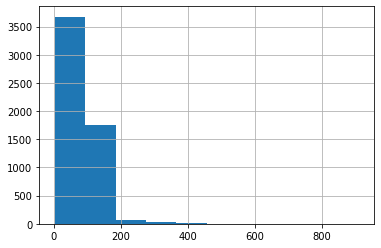

In [7]:
lens.hist()

Mostly short messages. In spam messages we can observe seeveral features:
 - More words in capital letters
 - More numbers
 - E-mail addresses 

We can use that features when preparing the data to tokenize spam messages right. 

In order to have more flexibility when applying the self-made naive bayes, i decided to make a function that will take preprocessed data as an input.

# **Part 1: DIY Naive Bayes classifier**

Define the function for Naive Bayes classifier with extra parameters. The algorithm that was used for the culculation is presented in [Speech and Language Precessing. Daniel Jurafsky and James H Martin, Chapter 4: Naive Bayes and Sentiment Classification](https://web.stanford.edu/~jurafsky/slp3/4.pdf).

In [0]:
def NBC_kfv(smslist, labellist, n_splits = 5, alpha = 1,metric = 'accuracy'):
  '''A function takes as an input list messages (organized as list of lists, with tokinized and prepared data),
  list of labels (values 0 or 1, where 1 is spam), number of splits, alpha parameter for smoothing and
  metric to use: accuracy, f1-score, recall or precision'''
  smslist = np.array(smslist)
  labellist = np.array(labellist) 
  # create list for storing metrics 
  result = []
  result_ham = []
  result_spam = []
  skf = StratifiedKFold(n_splits=n_splits)
  # perform k-fold validation on observations, iterate over subsets
  for train_index, test_index in skf.split(smslist,labellist):
    X_train, X_test = smslist[train_index], smslist[test_index]
    y_train, y_test = labellist[train_index], labellist[test_index]
    # get the vocabulart of a subset
    vocab = []
    for sms in X_train:
      for word in sms:
        if word not in vocab:
          vocab.append(word)
    # culc the prior probability of classes
    spam_prob = y_train.mean()
    ham_prob = 1 - spam_prob
    # create "bigdocs", containing all the words of each class
    spam_sms = []
    ham_sms = []
    for i in range(len(y_train)):
      if labellist[i] == 1:
        spam_sms.append(X_train[i])
      else:
        ham_sms.append(X_train[i])
    flat_spam_sms = [word1 for sms in spam_sms for word1 in sms]
    flat_ham_sms = [word2 for sms in ham_sms for word2 in sms]
    # make prediction over test sample
    y_pred = []
    # iterate over all massages in test sample
    for sms in X_test:
      test_spam_prob = np.log(spam_prob)
      test_ham_prob = np.log(ham_prob)
      # iterate over all words in a message
      for word in sms:
        # culculate probabilities of a sms appear in spam and ham classes
        test_spam_prob += np.log(
              ((flat_spam_sms.count(word)+alpha)/
               (len(flat_spam_sms)+len(vocab)*alpha)))
        test_ham_prob += np.log(
              ((flat_ham_sms.count(word)+alpha)/
               (len(flat_ham_sms)+len(vocab)*alpha)))
      # compare the probabilities and append classes values
      if test_spam_prob > test_ham_prob:
        y_pred.append(1)
      else:
        y_pred.append(0)
    # define metric scores
    if metric == 'accuracy':
      result.append(accuracy_score(y_test,y_pred))
    elif metric == 'f1-score':
      result_spam.append(classification_report(y_test,np.array(y_pred),output_dict = True)['1'][metric]) 
      result_ham.append(classification_report(y_test,np.array(y_pred),output_dict = True)['0'][metric])
    elif metric == 'recall':
      result_spam.append(classification_report(y_test,np.array(y_pred),output_dict = True)['1'][metric]) 
      result_ham.append(classification_report(y_test,np.array(y_pred),output_dict = True)['0'][metric])
    elif metric == 'precision':
      result_spam.append(classification_report(y_test,np.array(y_pred),output_dict = True)['1'][metric]) 
      result_ham.append(classification_report(y_test,np.array(y_pred),output_dict = True)['0'][metric])
  if metric == 'accuracy':
    return print("Accuracies for 5-fold validation are: ", [round(x,4) for x in result]) 
  else:
    return print(metric,"for spam class are: ", [round(x,4) for x in result_spam], '\n',
                 metric,"for ham class are: ", [round(x,4) for x in result_ham])

Data preparation. I decided not to remove stop words and make stemming as in is not a good idea for spam detection task, as discussed in [Contributions to the Study of SMS Spam Filtering:
New Collection and Results](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/doceng11.pdf)

In [0]:
SMSs = df['message']
labels = df['label']
labels = [1 if i == 'spam' else 0 for i in labels]

In [0]:
#define punt removing function
def remove_punctuation(x):
  return x.translate(str.maketrans('', '', string.punctuation))

In [0]:
# apply lowering, removing puntuation and tokenizing sms
SMSs = SMSs.str.lower()
SMSs = SMSs.apply(remove_punctuation)
SMSs = SMSs.apply(word_tokenize)
SMSs = SMSs.to_list()

In [15]:
# choose the metric and perform NBC, let's for example see at accuracy
NBC_kfv(SMSs,labels, metric='accuracy')

Accuracies for 5-fold validation are:  [0.8368, 0.9283, 0.9623, 0.9767, 0.9749]


We can observe a pretty high accuracy score for almost all k-fold splits. The first one is a kind of outlier. Let's look, for example to recalls:

In [16]:
# choose the metric and perform NBC, let's for example see at accuracy
NBC_kfv(SMSs,labels, metric='recall')

recall for spam class are:  [0.1867, 0.7067, 0.8792, 0.9329, 0.953] 
 recall for ham class are:  [0.9378, 0.9627, 0.9751, 0.9834, 0.9782]


You can see very low spam recallin 1st split. I believe this happens due to the fact that in 1st fold there are "less recognizable" spam messages, than in other folds. Leet's change the number of splits, hopefully, it will smooth the situation.

In [17]:
# choose the metric and perform NBC, let's for example see at accuracy
NBC_kfv(SMSs,labels, metric='recall', n_splits = 4)

recall for spam class are:  [0.1183, 0.7594, 0.9091, 0.9572] 
 recall for ham class are:  [0.9337, 0.9577, 0.9801, 0.9784]


Now, it didn't :( I give up.

# **Part 2: use of sklearn Naive Bayes classifier**

Now let's move on to built in sklearn naive bayes classifier. I found CountVerctorizer method in web and used it to quickly prepare the data.

In [0]:
# import the data one more time
df = pd.read_csv('SMSSpamCollection', encoding = 'latin_1', sep='\t', header = None)
df.columns = ['label', 'message']
df['label'] = df.label.map({'ham':0,'spam':1})

In [0]:
# split the data to train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df['message'],df['label'],test_size=0.3)

In [0]:
# Initialize CountVectorizer method
count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)

In [21]:
# perform built in classifier and show the metrics
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train,y_train)
predictions = naive_bayes.predict(X_test)
print('Accuracy is ', round(accuracy_score(y_test, predictions),4))
print('f1-score is ', round(f1_score(y_test, predictions),4))
print('Recall of spam is ', round(recall_score(y_test, predictions),4))
print('Precision of spam is ', round(precision_score(y_test, predictions),4))

Accuracy is  0.9916
f1-score is  0.9662
Recall of spam is  0.9479
Precision of spam is  0.9852


Well, for just one split built in function did better job that mine self-made. At least all the scores look higher than mine. Probably, CountVectorizer performed better that my data preprocessing. As i've mentions in the beginning, Spam messages have several special features, so the results of analysis are sensitive to the way you preprocessed you data.